<h1>IMPORTS</h1>

In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

#feature extracton
import pywt
from skimage.feature import graycomatrix, graycoprops
from scipy.fftpack import fft2 ,fftshift 

#feature selection and model
from sklearn.feature_selection import chi2, RFECV, SequentialFeatureSelector, RFE
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, classification_report
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
import seaborn as sns




<h1>Reading of CSV file</h1>

In [2]:
data = pd.read_csv("Monkeypox_Dataset_metadata.csv")
data

,ImageID,Label
0,M01_01,Monkeypox
1,M01_02,Monkeypox
2,M01_03,Monkeypox
3,M01_04,Monkeypox
4,M02_01,Monkeypox
...,...,...
223,NM106_01,Non Monkeypox
224,NM107_01,Non Monkeypox
225,NM108_01,Non Monkeypox
226,NM109_01,Non Monkeypox


**detecting if there in null values in csv file**

In [3]:
print(data.isnull().sum())  

ImageID    0
Label      0
dtype: int64


<hr>
<h1>Encoding the classes and adding image new paths</h1>
<hr>

In [4]:
data["Label"] = data["Label"].map({"Non Monkeypox": 0, "Monkeypox": 1})
print("data before",data)

data["image_path"] = data.apply(
    lambda row: os.path.join("D:/Study/CAD/project_data/others_grey", row["ImageID"]) + ".jpg"
    if row["Label"] == 0 else 
    os.path.join("D:/Study/CAD/project_data/monkeypox_grey", row["ImageID"]) + ".jpg", 
    axis=1
)
print(data)

data before       ImageID  Label
0      M01_01      1
1      M01_02      1
2      M01_03      1
3      M01_04      1
4      M02_01      1
..        ...    ...
223  NM106_01      0
224  NM107_01      0
225  NM108_01      0
226  NM109_01      0
227  NM110_01      0

[228 rows x 2 columns]
      ImageID  Label                                         image_path
0      M01_01      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...
1      M01_02      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...
2      M01_03      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...
3      M01_04      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...
4      M02_01      1  D:/Study/CAD/project_data/monkeypox_grey\M02_0...
..        ...    ...                                                ...
223  NM106_01      0  D:/Study/CAD/project_data/others_grey\NM106_01...
224  NM107_01      0  D:/Study/CAD/project_data/others_grey\NM107_01...
225  NM108_01      0  D:/Study/CAD/project_data/others_grey\NM10

<hr>
<h1>Calculating no. of images in CSV file and folder</h1>
<br>
to check if both are equal and nothing is missing
<hr>

In [5]:
print("monkeypox in csv: ",sum(data["Label"] == 1)) 
print("others in csv: ",sum(data["Label"] == 0) )

monkeypox in csv:  102
others in csv:  126


In [6]:
monkeypox_count = sum(1 for file in os.listdir(r"Original Images\Original Images\Monkey Pox") if file.lower().endswith(".jpg"))
others_count = sum(1 for file in os.listdir(r"Original Images\Original Images\Others") if file.lower().endswith(".jpg"))
print(f"Number of images in monkeypox folder: = {monkeypox_count}")
print(f"Number of images in others folder: = {others_count}")

Number of images in monkeypox folder: = 102
Number of images in others folder: = 126


<h1>Pie chart</h1> <br>
to show the distribution of the two classes

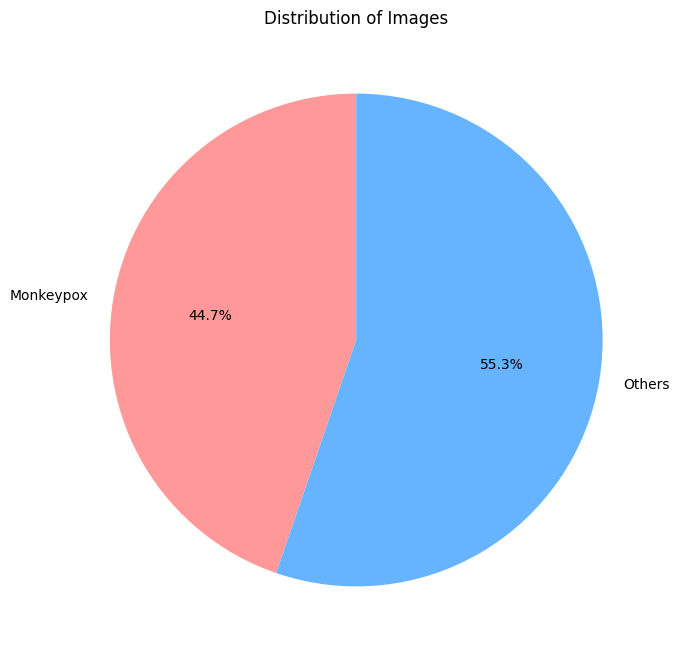

In [7]:
plt.figure(figsize=(8, 8))
plt.pie([monkeypox_count, others_count], labels=["Monkeypox", "Others"], autopct='%1.1f%%', startangle=90, colors=["#ff9999", "#66b3ff"])
plt.title("Distribution of Images")
plt.show()

**the difference between the two classes is not significent so we don't need to do oversampling or undersampling**

<hr>
<h1>Creating folders to add the new enhanced greyscaled image</h1>
<hr>

In [8]:
output_monkeypox = r"D:\Study\CAD\project_data\monkeypox_grey"
input_monkeypox = r"Original Images\Original Images\Monkey Pox"
output_others = r"D:\Study\CAD\project_data\others_grey"
input_others = r"Original Images\Original Images\Others"

if not os.path.exists(output_monkeypox):
    os.makedirs(output_monkeypox)
    print(f"Created output folder: {output_monkeypox}")
else:
    print(f"Output folder already exists: {output_monkeypox}")


if not os.path.exists(output_others):    
    os.makedirs(output_others)
    print(f"Created output folder: {output_others}")
else:
    print(f"Output folder already exists: {output_others}")


Output folder already exists: D:\Study\CAD\project_data\monkeypox_grey
Output folder already exists: D:\Study\CAD\project_data\others_grey


<hr>
<h1>Enhancing image using CALHE then saving them in their new directories</h1>
<hr>

In [9]:
def adaptive_contrast_stretching(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(image)
    normalized_image = clahe_image / 255
    img = np.uint8(normalized_image * 255)
    return img


In [10]:
if not bool(os.listdir(output_monkeypox)):
    for file_name in os.listdir(input_monkeypox):
        if file_name.lower().endswith(".jpg"):
            input_path = os.path.join(input_monkeypox, file_name)
            output_path = os.path.join(output_monkeypox, file_name)
            
            grayscale_image = cv2.imread(input_path,0)
                       
            stretched_image = adaptive_contrast_stretching(grayscale_image)

            cv2.imwrite(output_path, stretched_image)
            print(f"Processed and saved: {output_path}")
else:
    print(f"Output folder is not empty")

            

Output folder is not empty


In [11]:
if not bool(os.listdir(output_others)):
    for file_name in os.listdir(input_others):
        if file_name.lower().endswith(".jpg"):
            input_path = os.path.join(input_others, file_name)
            output_path = os.path.join(output_others, file_name)
            
            grayscale_image = cv2.imread(input_path,0)
            
            stretched_image = adaptive_contrast_stretching(grayscale_image)
            
            cv2.imwrite(output_path, stretched_image)
            print(f"Processed and saved: {output_path}")
else:
    print(f"Output folder is not empty")

Output folder is not empty


<h1>Checking if all the images has been enhanced and saved</h1> <br>
the images are normalized too after being enhanced so the features won't be lost if the steps are reversed

In [12]:
monkeypox_count = sum(1 for file in os.listdir(r"monkeypox_grey") if file.lower().endswith(".jpg"))
others_count = sum(1 for file in os.listdir(r"others_grey") if file.lower().endswith(".jpg"))
print(f"Number of images in monkeypox folder = {monkeypox_count}")
print(f"Number of images in others folder = {others_count}")

Number of images in monkeypox folder = 102
Number of images in others folder = 126


<hr>
<h1>Checking an output image of each class (after/before)</h1>
<hr>

In [13]:
other_grey=cv2.imread(r"others_grey/NM31_01.jpg")
other_original=cv2.imread(r"Original Images\Original Images\Others\NM31_01.jpg")
other_original = cv2.cvtColor(other_original, cv2.COLOR_BGR2RGB)
monkeypox_grey=cv2.imread(r"monkeypox_grey/M29_01.jpg")
monkeypox_original=cv2.imread(r"Original Images\Original Images\Monkey Pox\M29_01.jpg")
monkeypox_original = cv2.cvtColor(monkeypox_original, cv2.COLOR_BGR2RGB)

print(other_grey.shape)
print(other_grey.dtype)

print(other_original.shape)
print(other_original.dtype)

print(monkeypox_grey.shape)
print(monkeypox_grey.dtype)

print(monkeypox_original.shape)
print(monkeypox_original.dtype)

(224, 224, 3)
uint8
(224, 224, 3)
uint8
(224, 224, 3)
uint8
(224, 224, 3)
uint8


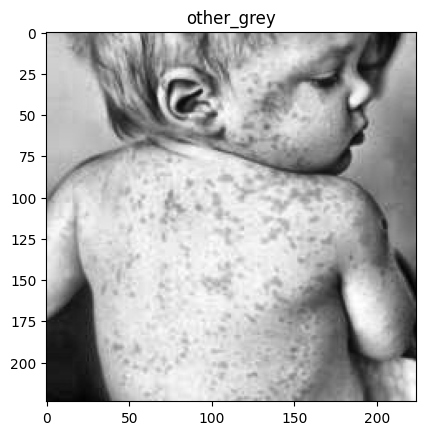

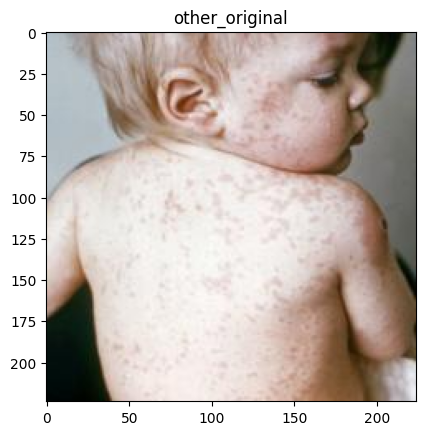

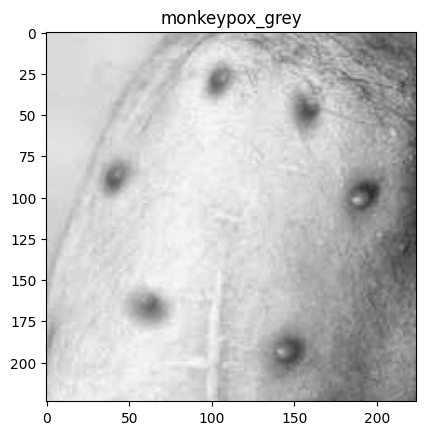

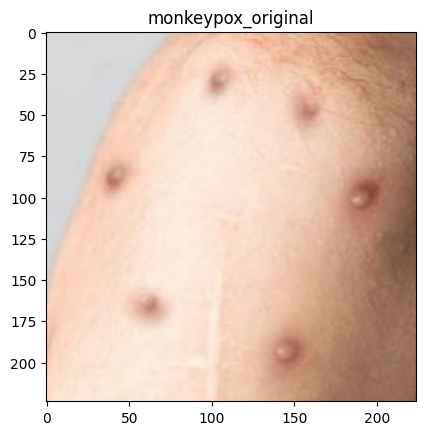

In [14]:
plt.imshow(other_grey)
plt.title("other_grey")
plt.show()

plt.imshow(other_original)
plt.title("other_original")
plt.show()

plt.imshow(monkeypox_grey)
plt.title("monkeypox_grey")
plt.show()

plt.imshow(monkeypox_original)
plt.title("monkeypox_original")
plt.show()

<h1>Feature Extraction</h1>
<h2>1. spatial domain => GLCM</h2>

**I also added every calculation of every image to the dataframe**

In [15]:
data["contrast"] = None
data["homogeneity"] = None
data["dissimilarity"] = None
data["energy"] = None
data["correlation"] = None

for index, row in data.iterrows():
    image_path = row["image_path"]
    
    image = cv2.imread(image_path,0).astype(np.uint8)
   
    glcm = graycomatrix(image, distances=[1], angles=[0, np.pi/2], levels=256, symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast').flatten()[0]
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()[0]
    dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()[0]
    energy = graycoprops(glcm, 'energy').flatten()[0]
    correlation = graycoprops(glcm, 'correlation').flatten()[0]

    data.loc[index, "contrast"] = contrast
    data.loc[index, "homogeneity"] = homogeneity
    data.loc[index, "dissimilarity"] = dissimilarity
    data.loc[index, "energy"] = energy
    data.loc[index, "correlation"] = correlation

print(data)

      ImageID  Label                                         image_path  \
0      M01_01      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...   
1      M01_02      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...   
2      M01_03      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...   
3      M01_04      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...   
4      M02_01      1  D:/Study/CAD/project_data/monkeypox_grey\M02_0...   
..        ...    ...                                                ...   
223  NM106_01      0  D:/Study/CAD/project_data/others_grey\NM106_01...   
224  NM107_01      0  D:/Study/CAD/project_data/others_grey\NM107_01...   
225  NM108_01      0  D:/Study/CAD/project_data/others_grey\NM108_01...   
226  NM109_01      0  D:/Study/CAD/project_data/others_grey\NM109_01...   
227  NM110_01      0  D:/Study/CAD/project_data/others_grey\NM110_01...   

       contrast homogeneity dissimilarity    energy correlation  
0     50.884469    0.194447      

<p> <strong>Note:</strong> I had an issue installing pyradiomics to use the  GLRLM built in functions 
</p>

<h2>2. Fourier transform</h2>

In [16]:
data["energy_from_fft"] = None
data["entropy_from_fft"] = None

for index, row in data.iterrows():
    image_path = row["image_path"]
    
    image = cv2.imread(image_path,0).astype(np.uint8)
   
    f = fft2(image)
    fshift = fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift))

    energy = np.sum(magnitude_spectrum**2) 
    entropy = -np.sum(magnitude_spectrum * np.log(magnitude_spectrum + 1e-9)) 

    data.loc[index, "energy_from_fft"] = energy
    data.loc[index, "entropy_from_fft"] = entropy

print(data)

C:\Users\salma\AppData\Local\Temp\ipykernel_6128\634821212.py:14: RuntimeWarning: invalid value encountered in log
  entropy = -np.sum(magnitude_spectrum * np.log(magnitude_spectrum + 1e-9))
C:\Users\salma\AppData\Local\Temp\ipykernel_6128\634821212.py:14: RuntimeWarning: invalid value encountered in log
  entropy = -np.sum(magnitude_spectrum * np.log(magnitude_spectrum + 1e-9))
C:\Users\salma\AppData\Local\Temp\ipykernel_6128\634821212.py:14: RuntimeWarning: invalid value encountered in log
  entropy = -np.sum(magnitude_spectrum * np.log(magnitude_spectrum + 1e-9))
C:\Users\salma\AppData\Local\Temp\ipykernel_6128\634821212.py:14: RuntimeWarning: invalid value encountered in log
  entropy = -np.sum(magnitude_spectrum * np.log(magnitude_spectrum + 1e-9))
C:\Users\salma\AppData\Local\Temp\ipykernel_6128\634821212.py:14: RuntimeWarning: invalid value encountered in log
  entropy = -np.sum(magnitude_spectrum * np.log(magnitude_spectrum + 1e-9))
C:\Users\salma\AppData\Local\Temp\ipykernel_6

      ImageID  Label                                         image_path  \
0      M01_01      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...   
1      M01_02      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...   
2      M01_03      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...   
3      M01_04      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...   
4      M02_01      1  D:/Study/CAD/project_data/monkeypox_grey\M02_0...   
..        ...    ...                                                ...   
223  NM106_01      0  D:/Study/CAD/project_data/others_grey\NM106_01...   
224  NM107_01      0  D:/Study/CAD/project_data/others_grey\NM107_01...   
225  NM108_01      0  D:/Study/CAD/project_data/others_grey\NM108_01...   
226  NM109_01      0  D:/Study/CAD/project_data/others_grey\NM109_01...   
227  NM110_01      0  D:/Study/CAD/project_data/others_grey\NM110_01...   

       contrast homogeneity dissimilarity    energy correlation  \
0     50.884469    0.194447     

C:\Users\salma\AppData\Local\Temp\ipykernel_6128\634821212.py:14: RuntimeWarning: invalid value encountered in log
  entropy = -np.sum(magnitude_spectrum * np.log(magnitude_spectrum + 1e-9))
C:\Users\salma\AppData\Local\Temp\ipykernel_6128\634821212.py:14: RuntimeWarning: invalid value encountered in log
  entropy = -np.sum(magnitude_spectrum * np.log(magnitude_spectrum + 1e-9))
C:\Users\salma\AppData\Local\Temp\ipykernel_6128\634821212.py:14: RuntimeWarning: invalid value encountered in log
  entropy = -np.sum(magnitude_spectrum * np.log(magnitude_spectrum + 1e-9))


<h2>3. Wavelet transform</h2>

In [17]:
for index, row in data.iterrows():
    image_path = row["image_path"]

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    coeffs = pywt.wavedec2(image, wavelet='haar', level=1)

    cA = coeffs[0]
    approximation_energy = np.sum(cA ** 2)
    approximation_entropy = -np.sum((np.abs(cA) / np.sum(np.abs(cA))) * np.log2(np.abs(cA) / np.sum(np.abs(cA)) + 1e-10))
    
    data.loc[index, "Approximation_Energy"] = approximation_energy
    data.loc[index, "Approximation_Entropy"] = approximation_entropy

    for level, (cH, cV, cD) in enumerate(coeffs[1:], start=1):
        horizontal_energy = np.sum(cH ** 2)
        vertical_energy = np.sum(cV ** 2)
        diagonal_energy = np.sum(cD ** 2)
        
        horizontal_entropy = -np.sum((np.abs(cH) / np.sum(np.abs(cH))) * np.log2(np.abs(cH) / np.sum(np.abs(cH)) + 1e-10))
        vertical_entropy = -np.sum((np.abs(cV) / np.sum(np.abs(cV))) * np.log2(np.abs(cV) / np.sum(np.abs(cV)) + 1e-10))
        diagonal_entropy = -np.sum((np.abs(cD) / np.sum(np.abs(cD))) * np.log2(np.abs(cD) / np.sum(np.abs(cD)) + 1e-10))

        data.loc[index, f"horizontal_energy_L{level}"] = horizontal_energy
        data.loc[index, f"vertical_energy_L{level}"] = vertical_energy
        data.loc[index, f"diagonal_energy_L{level}"] = diagonal_energy
        data.loc[index, f"horizontal_entropy_L{level}"] = horizontal_entropy
        data.loc[index, f"vertical_entropy_L{level}"] = vertical_entropy
        data.loc[index, f"diagonal_entropy_L{level}"] = diagonal_entropy

print(data)


      ImageID  Label                                         image_path  \
0      M01_01      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...   
1      M01_02      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...   
2      M01_03      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...   
3      M01_04      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...   
4      M02_01      1  D:/Study/CAD/project_data/monkeypox_grey\M02_0...   
..        ...    ...                                                ...   
223  NM106_01      0  D:/Study/CAD/project_data/others_grey\NM106_01...   
224  NM107_01      0  D:/Study/CAD/project_data/others_grey\NM107_01...   
225  NM108_01      0  D:/Study/CAD/project_data/others_grey\NM108_01...   
226  NM109_01      0  D:/Study/CAD/project_data/others_grey\NM109_01...   
227  NM110_01      0  D:/Study/CAD/project_data/others_grey\NM110_01...   

       contrast homogeneity dissimilarity    energy correlation  \
0     50.884469    0.194447     

<h2>4. Discrete Cosine Transform</h2>

In [18]:
for index, row in data.iterrows():

    image_path = row["image_path"]

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    dct_image = cv2.dct(np.float32(image))

    top_left = dct_image[:image.shape[0]//2, :image.shape[1]//2]

    energy = np.sum(top_left ** 2)

    normalized = np.abs(top_left) / np.sum(np.abs(top_left))  
    entropy = -np.sum(normalized * np.log2(normalized + 1e-10)) 

    data.loc[index, 'DCT_Energy'] = energy
    data.loc[index, 'DCT_Entropy'] = entropy
print(data)    


      ImageID  Label                                         image_path  \
0      M01_01      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...   
1      M01_02      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...   
2      M01_03      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...   
3      M01_04      1  D:/Study/CAD/project_data/monkeypox_grey\M01_0...   
4      M02_01      1  D:/Study/CAD/project_data/monkeypox_grey\M02_0...   
..        ...    ...                                                ...   
223  NM106_01      0  D:/Study/CAD/project_data/others_grey\NM106_01...   
224  NM107_01      0  D:/Study/CAD/project_data/others_grey\NM107_01...   
225  NM108_01      0  D:/Study/CAD/project_data/others_grey\NM108_01...   
226  NM109_01      0  D:/Study/CAD/project_data/others_grey\NM109_01...   
227  NM110_01      0  D:/Study/CAD/project_data/others_grey\NM110_01...   

       contrast homogeneity dissimilarity    energy correlation  \
0     50.884469    0.194447     

In [19]:
print(data.describe()) 

            Label  Approximation_Energy  Approximation_Entropy  \
count  228.000000          2.280000e+02             228.000000   
mean     0.447368          1.218021e+09              13.541424   
std      0.498316          4.019878e+08               0.082213   
min      0.000000          3.252186e+08              13.106864   
25%      0.000000          8.933173e+08              13.528333   
50%      0.000000          1.191771e+09              13.569862   
75%      1.000000          1.510860e+09              13.590397   
max      1.000000          2.477838e+09              13.611765   

       horizontal_energy_L1  vertical_energy_L1  diagonal_energy_L1  \
count          2.280000e+02        2.280000e+02        2.280000e+02   
mean           1.526787e+06        1.556141e+06        2.423471e+05   
std            1.804644e+06        2.186782e+06        9.855388e+05   
min            5.816000e+04        6.232475e+04        2.083250e+03   
25%            5.232568e+05        5.036359e+05   

<h1>Feature selection</h1>

<h2>1. Information gain</h2>

In [20]:
target_counts = data['Label'].value_counts(normalize=True)
total_entropy = -np.sum(target_counts * np.log2(target_counts + 1e-10))  

information_gains = {}

for feature in data.columns[3:]:

    unique_values = data[feature].unique()
    conditional_entropy = 0

    for value in unique_values:
        subset = data[data[feature] == value]
        subset_size = len(subset)
        subset_probabilities = subset['Label'].value_counts(normalize=True)
        subset_entropy = -np.sum(subset_probabilities * np.log2(subset_probabilities + 1e-10))  # Add small value to avoid log(0)
        conditional_entropy += (subset_size / len(data)) * subset_entropy

    information_gain = total_entropy - conditional_entropy
    information_gains[feature] = information_gain

print("Information Gain for each feature:")
for feature, gain in information_gains.items():
    print(f"{feature}: {gain}")


Information Gain for each feature:
contrast: 0.9919924033095859
homogeneity: 0.9919924033095859
dissimilarity: 0.9919924033095859
energy: 0.9919924033095859
correlation: 0.9919924033095859
energy_from_fft: 0.9919924033095859
entropy_from_fft: 0.9919924032918687
Approximation_Energy: 0.9919924033095859
Approximation_Entropy: 0.9919924033095859
horizontal_energy_L1: 0.9919924033095859
vertical_energy_L1: 0.9919924033095859
diagonal_energy_L1: 0.9919924033095859
horizontal_entropy_L1: 0.9919924033095859
vertical_entropy_L1: 0.9919924033095859
diagonal_entropy_L1: 0.9919924033095859
DCT_Energy: 0.9919924033095859
DCT_Entropy: 0.9919924033095859


<h2>2. Fisher's score</h2>

In [21]:

features = data.columns[3:]  
target = data['Label']

fisher_scores = {}

for feature in features:

    class_0 = data[data['Label'] == 0][feature]
    class_1 = data[data['Label'] == 1][feature]
    
    mean_0 = np.mean(class_0)
    mean_1 = np.mean(class_1)
    var_0 = np.var(class_0)
    var_1 = np.var(class_1)
    
    fisher_score = ((mean_0 - mean_1) ** 2) / (var_0 + var_1 + 1e-10)  # Add a small value to prevent division by zero
    fisher_scores[feature] = fisher_score


fisher_score_df = pd.DataFrame(list(fisher_scores.items()), columns=['Feature', 'Fisher_Score']).sort_values(by='Fisher_Score', ascending=False)

print(fisher_score_df)

                  Feature  Fisher_Score
8   Approximation_Entropy      0.253556
7    Approximation_Energy      0.158452
15             DCT_Energy      0.157518
12  horizontal_entropy_L1      0.043761
4             correlation      0.038936
9    horizontal_energy_L1      0.021878
16            DCT_Entropy      0.015356
6        entropy_from_fft      0.008610
3                  energy      0.007402
1             homogeneity      0.005434
11     diagonal_energy_L1      0.005047
10     vertical_energy_L1      0.004532
2           dissimilarity      0.004426
14    diagonal_entropy_L1      0.002804
0                contrast      0.001139
5         energy_from_fft      0.000474
13    vertical_entropy_L1      0.000183


<h2>3. Chi score</h2>

In [22]:
data_cleaned = data.dropna(subset=data.columns[3:])

X = data_cleaned.iloc[:, 3:]  
y = data_cleaned['Label']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

chi2_scores, p_values = chi2(X_scaled, y)

chi2_results = pd.DataFrame({
    'Feature': X.columns,
    'Chi2_Score': chi2_scores,
    'p_value': p_values
}).sort_values(by='Chi2_Score', ascending=False)

print(chi2_results)


                  Feature  Chi2_Score   p_value
7    Approximation_Energy    1.337231  0.247523
15             DCT_Energy    1.323564  0.249953
8   Approximation_Entropy    0.865586  0.352180
9    horizontal_energy_L1    0.249567  0.617380
11     diagonal_energy_L1    0.162477  0.686886
12  horizontal_entropy_L1    0.132892  0.715452
5         energy_from_fft    0.049319  0.824252
4             correlation    0.048956  0.824891
10     vertical_energy_L1    0.044491  0.832943
13    vertical_entropy_L1    0.043880  0.834077
6        entropy_from_fft    0.040624  0.840266
16            DCT_Entropy    0.015431  0.901139
2           dissimilarity    0.011980  0.912844
0                contrast    0.008856  0.925024
1             homogeneity    0.004409  0.947060
14    diagonal_entropy_L1    0.000804  0.977382
3                  energy    0.000018  0.996585


<h2>2. Wrapper methods</h2>

<h2>1. Sequential Forward and Backward Feature Selection </h2>

In [23]:
X = data.iloc[:, 3:]   
y = data['Label']  

classifier = RandomForestClassifier(n_estimators=100, random_state=42)

sfs = SequentialFeatureSelector(classifier, direction='forward', n_features_to_select=5, scoring='roc_auc', cv=5, n_jobs=-1)
sfs.fit(X, y)

sbs = SequentialFeatureSelector(classifier, direction='backward', n_features_to_select=5, scoring='roc_auc', cv=5, n_jobs=-1)
sbs.fit(X, y)

sfs_selected_features = X.columns[sfs.get_support()]
sbs_selected_features = X.columns[sbs.get_support()]

print("Sequential Forward Selection - Selected Features:")
print(sfs_selected_features)

print("\nSequential Backward Selection - Selected Features:")
print(sbs_selected_features)


Sequential Forward Selection - Selected Features:
Index(['entropy_from_fft', 'Approximation_Energy', 'diagonal_energy_L1',
       'horizontal_entropy_L1', 'vertical_entropy_L1'],
      dtype='object')

Sequential Backward Selection - Selected Features:
Index(['homogeneity', 'entropy_from_fft', 'horizontal_energy_L1',
       'horizontal_entropy_L1', 'DCT_Energy'],
      dtype='object')


<h2>Training model for Sequential Forward and Backward 
Feature Selection </h2>

Model Evaluation for SFS Selected Features:
Accuracy: 0.7391
ROC-AUC: 0.8708
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.67      0.77        30
           1       0.58      0.88      0.70        16

    accuracy                           0.74        46
   macro avg       0.75      0.77      0.73        46
weighted avg       0.80      0.74      0.75        46

Confusion Matrix:
[[20 10]
 [ 2 14]]

Model Evaluation for SBS Selected Features:
Accuracy: 0.7174
ROC-AUC: 0.9146
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.63      0.75        30
           1       0.56      0.88      0.68        16

    accuracy                           0.72        46
   macro avg       0.73      0.75      0.71        46
weighted avg       0.78      0.72      0.72        46

Confusion Matrix:
[[19 11]
 [ 2 14]]


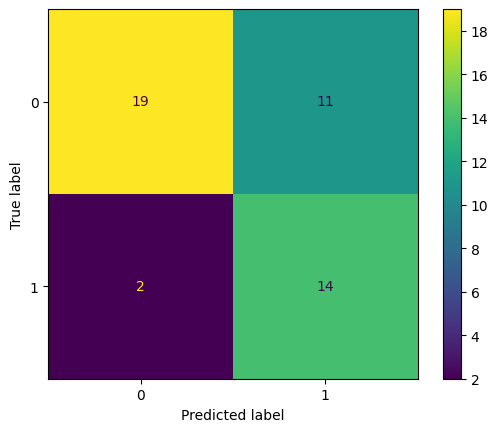

In [42]:

X_sfs = data[sfs_selected_features]  
X_sbs = data[sbs_selected_features]  
y = data['Label'] 

X_train_sfs, X_test_sfs, y_train, y_test = train_test_split(X_sfs, y, test_size=0.2, random_state=42)

X_train_sbs, X_test_sbs, _, _ = train_test_split(X_sbs, y, test_size=0.2, random_state=42)

classifier.fit(X_train_sfs, y_train)
y_pred_sfs = classifier.predict(X_test_sfs)
y_pred_proba_sfs = classifier.predict_proba(X_test_sfs)[:, 1]

# Train the model using SBS features
classifier.fit(X_train_sbs, y_train)
y_pred_sbs = classifier.predict(X_test_sbs)
y_pred_proba_sbs = classifier.predict_proba(X_test_sbs)[:, 1]

# Evaluate the model with SFS features
accuracy_sfs = accuracy_score(y_test, y_pred_sfs)
roc_auc_sfs = roc_auc_score(y_test, y_pred_proba_sfs)

# Evaluate the model with SBS features
accuracy_sbs = accuracy_score(y_test, y_pred_sbs)
roc_auc_sbs = roc_auc_score(y_test, y_pred_proba_sbs)

# Print results for SFS
print("Model Evaluation for SFS Selected Features:")
print(f"Accuracy: {accuracy_sfs:.4f}")
print(f"ROC-AUC: {roc_auc_sfs:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_sfs))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_sfs))

# Print results for SBS
print("\nModel Evaluation for SBS Selected Features:")
print(f"Accuracy: {accuracy_sbs:.4f}")
print(f"ROC-AUC: {roc_auc_sbs:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_sbs))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_sbs))

cm = confusion_matrix(y_test, y_pred_sbs)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

<h2>2. Exhaustive Feature Selection</h2>

In [24]:
"""import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.metrics import accuracy_score

X = data.drop(['Label', 'ImageID', 'image_path'], axis=1)  # Exclude non-feature columns
y = data['Label']  # Target variable (Label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()

efs = ExhaustiveFeatureSelector(
    estimator=model,
    min_features=1,
    max_features=X_train.shape[1],
    scoring='accuracy',
    cv=5
)

# Perform feature selection
efs = efs.fit(X_train.values, y_train)

selected_features = X_train.columns[efs.support_]

print("Selected features:", selected_features)

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

print("Accuracy on the test set:", accuracy)
"""

'import pandas as pd\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestClassifier\nfrom mlxtend.feature_selection import ExhaustiveFeatureSelector\nfrom sklearn.metrics import accuracy_score\n\nX = data.drop([\'Label\', \'ImageID\', \'image_path\'], axis=1)  # Exclude non-feature columns\ny = data[\'Label\']  # Target variable (Label)\n\n# Split the dataset into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Initialize the model (Random Forest Classifier in this case)\nmodel = RandomForestClassifier()\n\n# Initialize the Exhaustive Feature Selector\nefs = ExhaustiveFeatureSelector(\n    estimator=model,\n    min_features=1,\n    max_features=X_train.shape[1],\n    scoring=\'accuracy\',\n    cv=5\n)\n\n# Perform feature selection\nefs = efs.fit(X_train.values, y_train)\n\n# Get the selected features\nselected_features = X_train.columns[efs.support_]\n\n# Print the sel

<h2>1. Recrusive feature elimination (RFE)</h2>

Selected features: Index(['entropy_from_fft', 'Approximation_Energy', 'Approximation_Entropy',
       'vertical_entropy_L1', 'DCT_Energy'],
      dtype='object')
ROC-AUC: 0.7062
Accuracy: 0.6739
Precision: 0.52
Recall: 0.8125


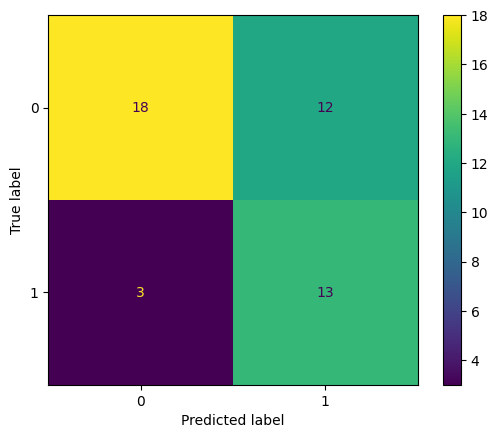

In [43]:

X = data.drop(['Label', 'ImageID', 'image_path'], axis=1) 
y = data['Label'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()

rfe = RFE(estimator=model, n_features_to_select=5)  

rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]

print("Selected features:", selected_features)

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc_sbs = roc_auc_score(y_test, y_pred)

print(f"ROC-AUC: {roc_auc_sbs:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("Precision:", precision)
print("Recall:", recall)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();



<h1>Hybrid feature selection</h1>
<h2>1. Filter Method: Pearson’s Correlation Coefficient</h2>
<h2>2. Wrapper Method: RFE</h2>

Features dropped due to high correlation: {'DCT_Energy', 'diagonal_energy_L1', 'entropy_from_fft', 'horizontal_energy_L1', 'vertical_energy_L1', 'dissimilarity'}
Selected features after RFE:
 ['energy_from_fft', 'Approximation_Energy', 'Approximation_Entropy', 'horizontal_entropy_L1', 'vertical_entropy_L1']


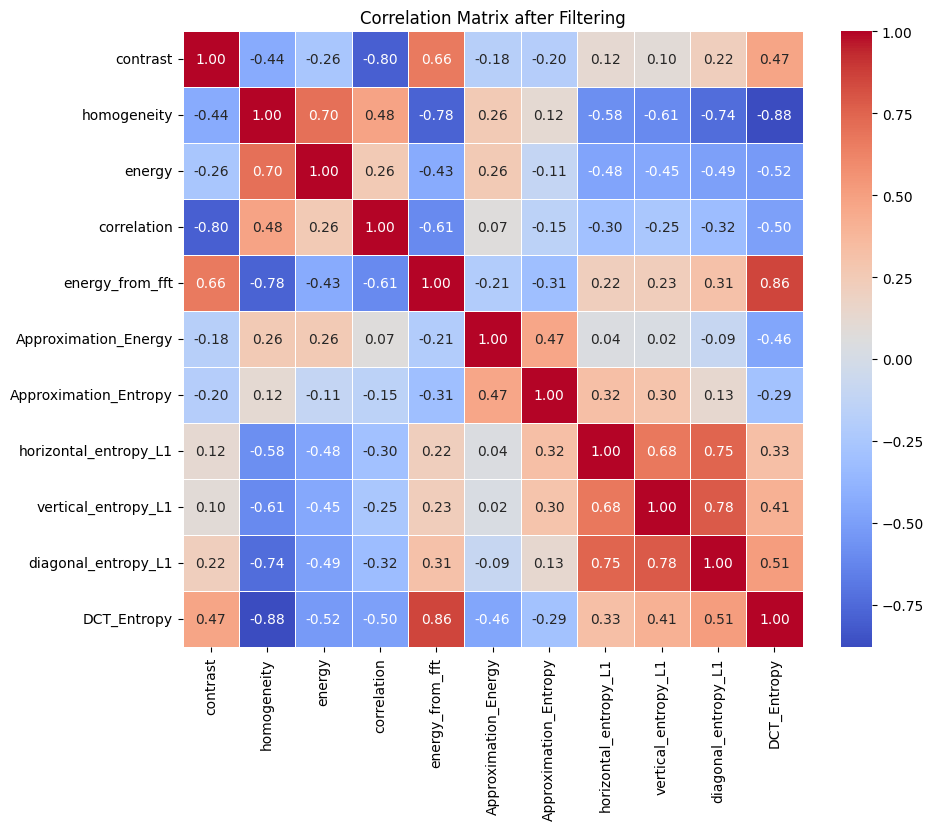

Final selected features after Hybrid Feature Selection:
 ['energy_from_fft', 'Approximation_Energy', 'Approximation_Entropy', 'horizontal_entropy_L1', 'vertical_entropy_L1']


In [26]:
X = data.drop(['Label', 'ImageID', 'image_path'], axis=1) 
y = data['Label'] 

correlation_matrix = X.corr()

correlation_threshold = 0.9
to_drop = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            to_drop.add(colname)

X_filtered = X.drop(columns=to_drop)
print("Features dropped due to high correlation:", to_drop)

model = RandomForestClassifier()

rfe = RFE(estimator=model, n_features_to_select=5)
X_rfe = X_filtered.copy()  

selected_features_rfe = X_rfe.columns[rfe.support_]

print(f"Selected features after RFE:\n {selected_features_rfe.tolist()}")

plt.figure(figsize=(10, 8))
sns.heatmap(X_filtered.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix after Filtering")
plt.show()

final_selected_features = selected_features_rfe.tolist()
print("Final selected features after Hybrid Feature Selection:\n", final_selected_features)


<h2>Training model</h2>

ROC-AUC: 0.8354
Accuracy: 0.8043
Precision: 0.6521739130434783
Recall: 0.9375


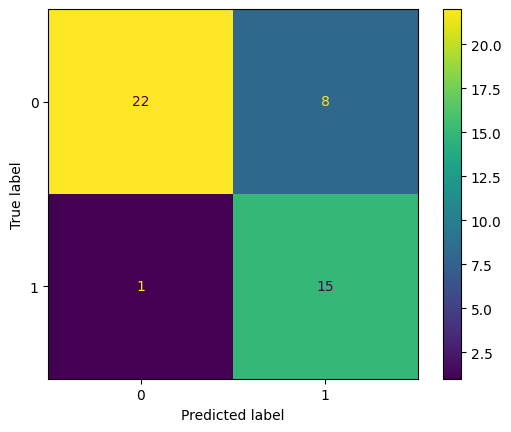

In [49]:

X_train, X_test, y_train, y_test = train_test_split(X[final_selected_features], y, test_size=0.2, random_state=42)

model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc_sbs = roc_auc_score(y_test, y_pred)

print(f"ROC-AUC: {roc_auc_sbs:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("Precision:", precision)
print("Recall:", recall)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

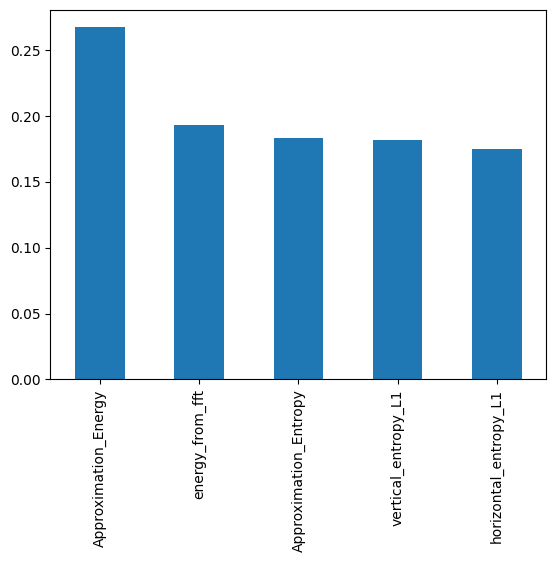

In [ ]:
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_importances.plot.bar();

<h3>References</h3>
https://www.datacamp.com/tutorial/random-forests-classifier-python